# Objective
* The objective of this exercise is to identify a fraudlent transaction as accurately as possible.
* Compare different models based on their performance

##### Import neccessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
## to ignore waarning
import warnings
warnings.filterwarnings("ignore")#, category=DeprecationWarning)

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


##### Load the dataset

In [2]:
data = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Exploratory Data Analysis

In [3]:
print("Number of records:\t\t",data.shape[0])
print("Number of features per record:\t",data.shape[1])

Number of records:		 6362620
Number of features per record:	 11


In [4]:
print("Any missing data?",data.isnull().sum().any())

Any missing data? False


In [5]:
#print("% of Valid transactions:",round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2))
#print("% of Fraud transactions:",round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2))

print("No of Valid transactions:",data.isFraud.value_counts()[0],'which is ',round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2),'%')
print("No of Fraud transactions:",data.isFraud.value_counts()[1],'which is ',round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2),'%')

data.isFraud.value_counts()

No of Valid transactions: 6354407 which is  99.87 %
No of Fraud transactions: 8213 which is  0.13 %


0    6354407
1       8213
Name: isFraud, dtype: int64

In [6]:
print("No of transactions Flagged as Valid:",data.isFlaggedFraud.value_counts()[0])
print("No of transactions Flagged as Fraud:",data.isFlaggedFraud.value_counts()[1])

No of transactions Flagged as Valid: 6362604
No of transactions Flagged as Fraud: 16


In [7]:
print("Are there any mismatch in the balance at origin and destination after transaction?")
data['error_orig'] = (data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"]).astype(int)
data['error_dest'] = (data["oldbalanceDest"] + data["amount"] != data["newbalanceDest"]).astype(int)

print("Balance Error(%) at the origin:",round(data['error_orig'].value_counts()[1]/data.shape[0] * 100,2))
print("Balance Error(%) at the destination:",round(data['error_dest'].value_counts()[1]/data.shape[0] * 100,2))

#print("Valid Balance(%) at the origin:",round(data['error_orig'].value_counts()[0]/data.shape[0] * 100,2))
#print("Valid Balance(%) at the dest:",round(data['error_dest'].value_counts()[0]/data.shape[0] * 100,2))

Are there any mismatch in the balance at origin and destination after transaction?
Balance Error(%) at the origin: 85.09
Balance Error(%) at the destination: 74.45


##### Appears the Fraud occurs both at sending and receiving ends

In [8]:
print("Any transaction with amount less than or equal to 0?")
print(len(data[data.amount<=0]))
print("What type of transactions are they?")
print(data[data.amount<=0]['type'].value_counts().index[0])
print("Are all these marked as Fraud Transactions?")
data[data.amount<=0]['isFraud'].value_counts()[1] == len(data[data.amount<=0])

Any transaction with amount less than or equal to 0?
16
What type of transactions are they?
CASH_OUT
Are all these marked as Fraud Transactions?


True

In [9]:
data_temp = data[data.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print("\t",len(data_temp))

print("What type of transactions are they?")
print("\t",data_temp['type'].value_counts().index[0])

print("Are all these flagged also marked as Fraud Transactions?")
print("\t",data_temp['isFraud'].value_counts()[1] == len(data_temp))

print("Minumum amount transfered in these transactions")
print("\t",data_temp.amount.min())

print("Maximum amount transfered in these transactions")
print("\t",data_temp.amount.max())

How many frauds transactions are Flagged?:
	 16
What type of transactions are they?
	 TRANSFER
Are all these flagged also marked as Fraud Transactions?
	 True
Minumum amount transfered in these transactions
	 353874.22
Maximum amount transfered in these transactions
	 10000000.0


### All the fraud trnasactions belong to Transfer or Cash-out type, so discard data corresponding to other types

In [10]:
data = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT']))]
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,error_orig,error_dest
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1


## Data Visualization

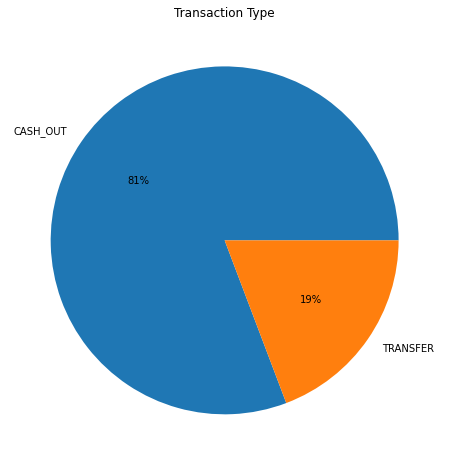

In [11]:
#create pie chart
plt.figure(figsize=(10,8))
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

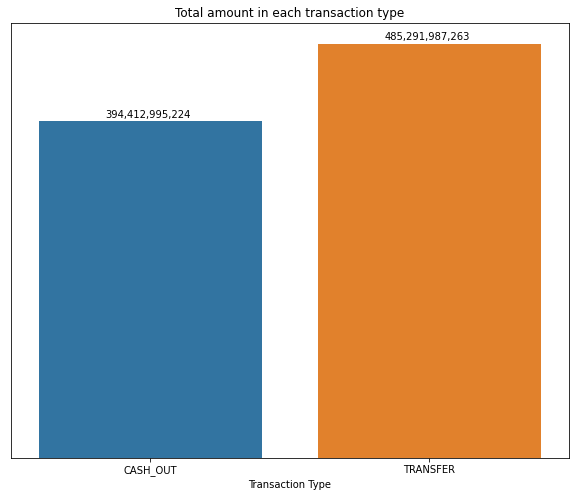

In [12]:
d = data.groupby('type')['amount'].sum()
plt.figure(figsize=(10,8))
ax = sns.barplot(x=d.index,y=d.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
    
plt.title("Total amount in each transaction type")
plt.yticks([])
plt.xlabel("Transaction Type")
plt.show()

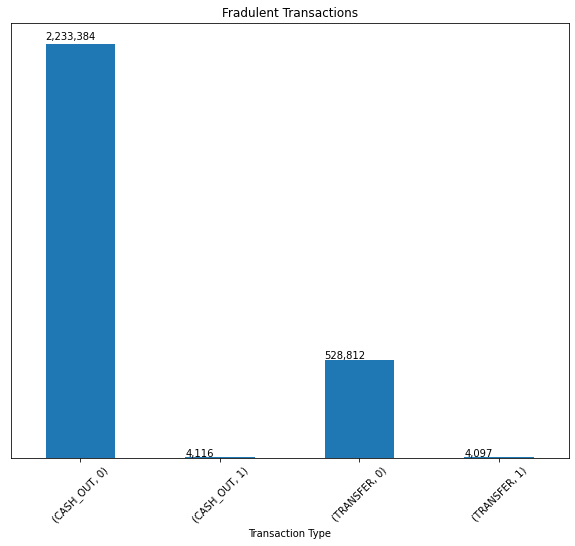

In [13]:
plt.figure(figsize=(10,8))
ax = data.groupby(['type','isFraud']).size().plot(kind='bar')

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.title("Fradulent Transactions")
plt.xlabel("Transaction Type")
plt.yticks([])
#plt.xticks([' Valid CashOut','Fraud CashOut','Valid Transfer','Fraud Transfer'])
plt.xticks(rotation=45)
plt.show()

#### Delete unwanted features (Remove isFlaggedFraud and keep isFraud as target feature)

In [14]:
data.drop(['step','type','nameOrig','nameDest','error_orig','error_dest','isFlaggedFraud'],axis=1,inplace=True)
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,181.00,181.0,0.0,0.0,0.00,1
3,181.00,181.0,0.0,21182.0,0.00,1
15,229133.94,15325.0,0.0,5083.0,51513.44,0
19,215310.30,705.0,0.0,22425.0,0.00,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0


#### Standardizing all the continuous values to be between 0 and 1

In [15]:
ss = StandardScaler()

data.amount         = ss.fit_transform(data[['amount']])
data.oldbalanceOrg  = ss.fit_transform(data[['oldbalanceOrg']])
data.oldbalanceDest = ss.fit_transform(data[['oldbalanceDest']])
data.newbalanceOrig = ss.fit_transform(data[['newbalanceOrig']])
data.newbalanceDest = ss.fit_transform(data[['newbalanceDest']])

In [16]:
X = data.drop(["isFraud"],axis=1)
y = data.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2077806, 5), (692603, 5), (2077806,), (692603,))

In [17]:
# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    
    plt.figure(figsize=(6,6))
    plt.title("Confusion Matrix")
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    

How many class does the model predict? [0 1]
Numbers in each class:		 0 : 691623
		 1 : 980
f1 score: 0.5954500494559841
Accuracy of this model: 0.9982284223429584


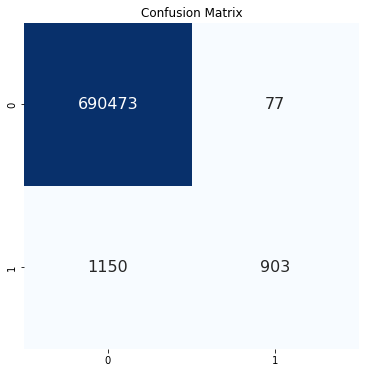

In [18]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print("How many class does the model predict?",np.unique( lr_pred ))
print("Numbers in each class:\t\t","0 :",len(lr_pred[lr_pred==0]))
print("\t\t 1 :",len(lr_pred[lr_pred==1]))

f1score = f1_score(y_test, lr_pred)
print('f1 score:', f1score)

conf_matrix(y_test, lr_pred)
 
acc_lr= accuracy_score(y_test, lr_pred)
print("Accuracy of this model:", acc_lr)

## Since the dataset extremely imbalanced, some workaround can be done to overcome this. Below are all the methods listed

# 1. Up-sample Minority Class
    Randomly duplicate the data from the minority class.

In [19]:
n = data.isFraud.value_counts()[0]

# Separate majority and minority classes
df_majority = data[data.isFraud==0]
df_minority = data[data.isFraud==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print("The new class count are :")
df_upsampled.isFraud.value_counts()

The new class count are :


0    2762196
1    2762196
Name: isFraud, dtype: int64

f1 score for the testing data:	 0.8971841120670441
Accuracy of thie model:		 0.900473391460997


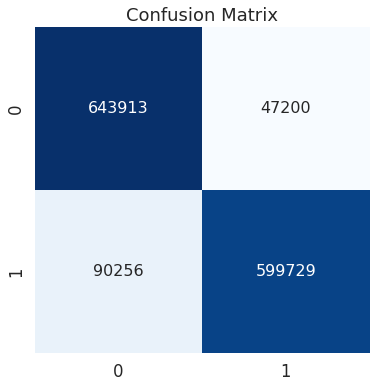

In [20]:
X = df_upsampled.drop(["isFraud"],axis = 1)
y = df_upsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

# Predicting on the test data
up_scale_pred = lr.predict(X_test)

#Calculating and printing the f1 score 
f1up_scale_pred = f1_score(y_test, up_scale_pred)
print('f1 score for the testing data:\t', f1up_scale_pred)

#Calling function 
conf_matrix(y_test,up_scale_pred)

acc_up_scale=accuracy_score(y_test, up_scale_pred)
print("Accuracy of thie model:\t\t",acc_up_scale)


# 2. Down-sample Majority Class
     Randomly remove data from the majority class

In [21]:
n = data.isFraud.value_counts()[1]

# Separate majority and minority classes

df_majority = data[data.isFraud==0]
df_minority = data[data.isFraud==1]

 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=n,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
print("The new class count are:")
print(df_downsampled.isFraud.value_counts())

The new class count are:
0    8213
1    8213
Name: isFraud, dtype: int64


How many class does the model predict? [0 1]
Count in each class:			 0 : 8918
					 1 : 7508
f1 score for the testing data:		 0.8760256981108073
Accuracy of the model:			 0.881346645561914


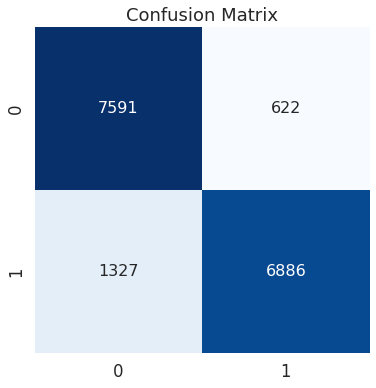

In [22]:
# Separate input features (X) and target variable (y)
y = df_downsampled.isFraud
X = df_downsampled.drop(['isFraud'], axis=1)
 
# Train model
lr = LogisticRegression().fit(X, y)
 
# Predict on training set
down_scale_pred = lr.predict(X)
 
print("How many class does the model predict?",np.unique( down_scale_pred ))
print("Count in each class:\t\t\t","0 :",len(down_scale_pred[down_scale_pred==0]))
print("\t\t\t\t\t 1 :",len(down_scale_pred[down_scale_pred==1]))

#Calculating and printing the f1 score 
f1down_scale_pred = f1_score(y, down_scale_pred)
print('f1 score for the testing data:\t\t', f1down_scale_pred)

conf_matrix(y, down_scale_pred)
      
acc_down_scale=accuracy_score(y, down_scale_pred) 
print("Accuracy of the model:\t\t\t", acc_down_scale)


# 3. Tree-Based Algorithms

In [23]:
# Separate input features (X) and target variable (y)
y = data.isFraud
X = data.drop(['isFraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# Predict on training set
rfc_pred = rfc.predict(X_test)

AUROC:			 0.9943859119226593
f1 score:		 0.8565400843881856
Accuracy of the model:	 0.9992145572571878


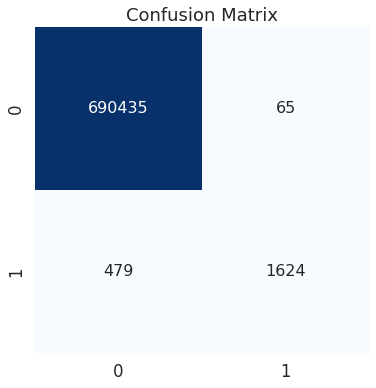

In [24]:

prob_y = rfc.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]

print("AUROC:\t\t\t",roc_auc_score(y_test, prob_y))

f1_rfc = f1_score(y_test, rfc_pred)
print('f1 score:\t\t', f1_rfc)

conf_matrix(y_test, rfc_pred)

acc_rfc=accuracy_score(y_test, rfc_pred) 
print("Accuracy of the model:\t", acc_rfc)


In [25]:
data = {'Model':['Logistic Regression','UpScale Logistic Regression','DownScale Logistic Regression','RandomForest'],
        'f1 score':[f1score,f1up_scale_pred,f1down_scale_pred,f1_rfc],
        'Accuracy Score':[acc_lr,acc_up_scale,acc_down_scale,acc_rfc]}

comparision_table=pd.DataFrame(data)                               
print(comparision_table)

                           Model  f1 score  Accuracy Score
0            Logistic Regression  0.595450        0.998228
1    UpScale Logistic Regression  0.897184        0.900473
2  DownScale Logistic Regression  0.876026        0.881347
3                   RandomForest  0.856540        0.999215
